### Forecasting Stock Market Returns using ARIMA

In [43]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
import statsmodels.api as sm
import plotly.figure_factory as ff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

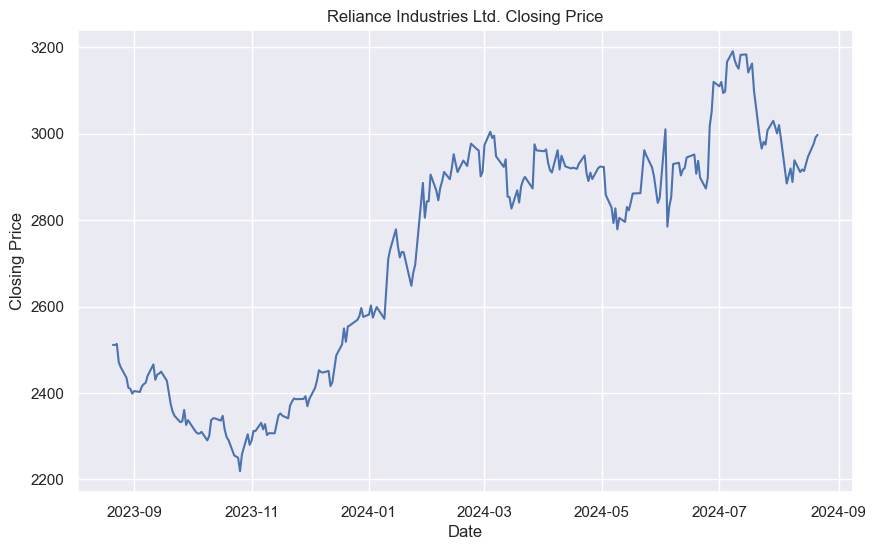

In [2]:
#importing reliance data from yfinance for one year



reliance = yf.Ticker("RELIANCE.NS")
reliance_data = reliance.history(period="1y")
reliance_data = reliance_data.dropna()
reliance_data['Date'] = reliance_data.index
reliance_data = reliance_data.reset_index(drop=True)

#plotting the closing price of reliance using seaborn

sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=reliance_data['Date'], y=reliance_data['Close'])
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()




In [3]:
#check for missing values
print(reliance_data.isnull().sum())

Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Date            0
dtype: int64


In [4]:
#stationarity check
from statsmodels.tsa.stattools import adfuller
test_results = adfuller(reliance_data['Close'])
print('ADF Statistic: %f' % test_results[0])    
print('p-value: %f' % test_results[1])
print('Critical Values:')
for key, value in test_results[4].items():
    print('\t%s: %.3f' % (key, value))
if test_results[1] < 0.05:
	print('Reject the null hypothesis: The time series is stationary.')
else:
	print('Failed to reject the null hypothesis: The time series is non-stationary.')


ADF Statistic: -0.810212
p-value: 0.816104
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Failed to reject the null hypothesis: The time series is non-stationary.


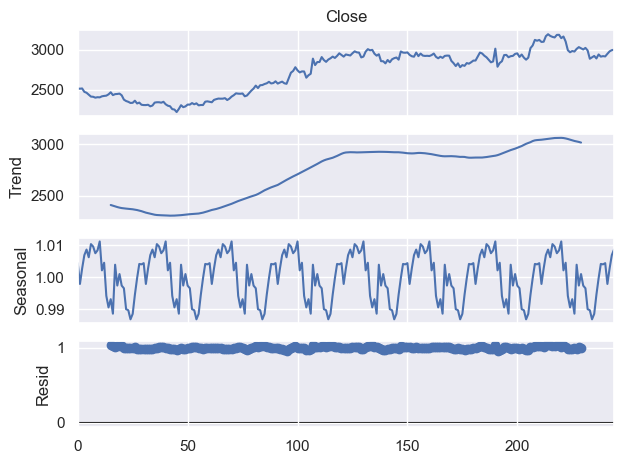

In [5]:
#seperating trend and seasonality
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(reliance_data['Close'], model='multiplicative', period=30)
result.plot()
plt.show()


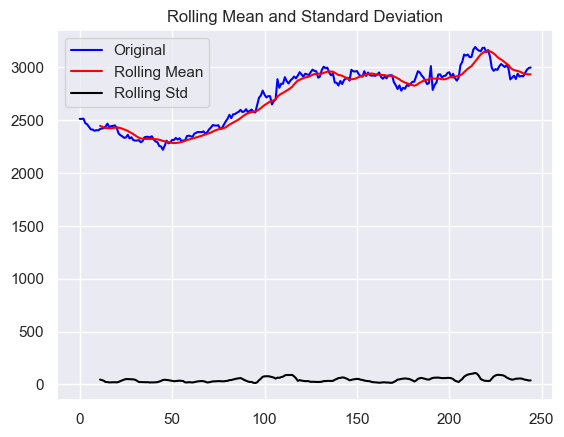

Results of dickey fuller test
Test Statistics                 -0.810212
p-value                          0.816104
No. of lags used                 1.000000
Number of observations used    243.000000
critical value (1%)             -3.457551
critical value (5%)             -2.873509
critical value (10%)            -2.573148
dtype: float64


In [6]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_stationarity(reliance_data['Close'])

In [7]:
# Check for stationarity
test_results = adfuller(reliance_data['Close'])
if test_results[1] < 0.05:
    print('The time series is already stationary.')
else:
    # Difference the data
    differenced_data = reliance_data['Close'].diff().dropna()

    # Check for stationarity again
    test_results = adfuller(differenced_data)
    if test_results[1] < 0.05:
        print('After differencing, the time series is stationary.')
    else:
        print('Differencing alone did not achieve stationarity. Additional steps may be required.')

After differencing, the time series is stationary.


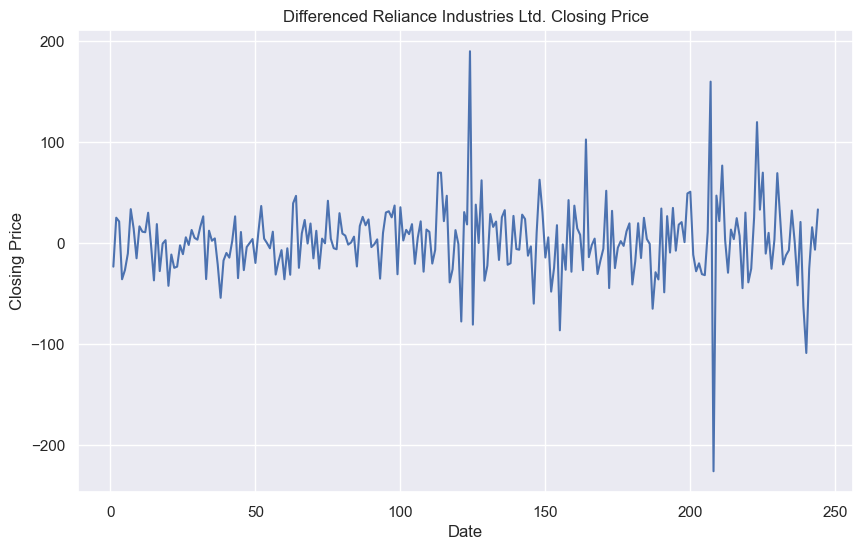

In [9]:
#plot the differenced data
plt.figure(figsize=(10, 6))
plt.plot(differenced_data)
plt.title('Differenced Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

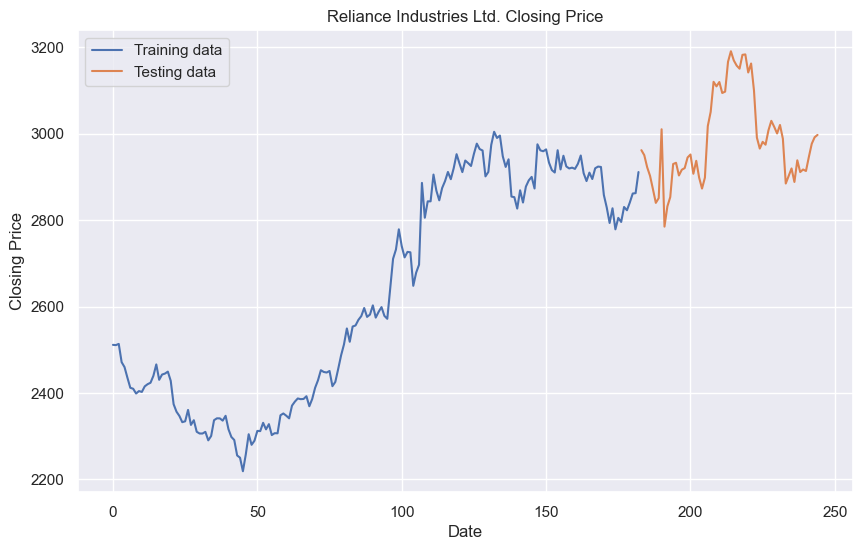

In [8]:
#splitting the data using train test split 75-25
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(reliance_data['Close'], train_size=0.75, shuffle=False)

#plotting the train and test data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training data')
plt.plot(test_data, label='Testing data')
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()



### ARIMA Predictions

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1775.167, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1773.464, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1774.070, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1774.056, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1773.585, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1770.579, Time=0.21 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1772.290, Time=0.25 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1772.215, Time=0.51 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1774.702, Time=0.13 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1764.969, Time=0.47 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1766.934, Time=0.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1767.170, Time=0.58 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1772.941, Time=0.30 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1773.499, Time=0.35 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept

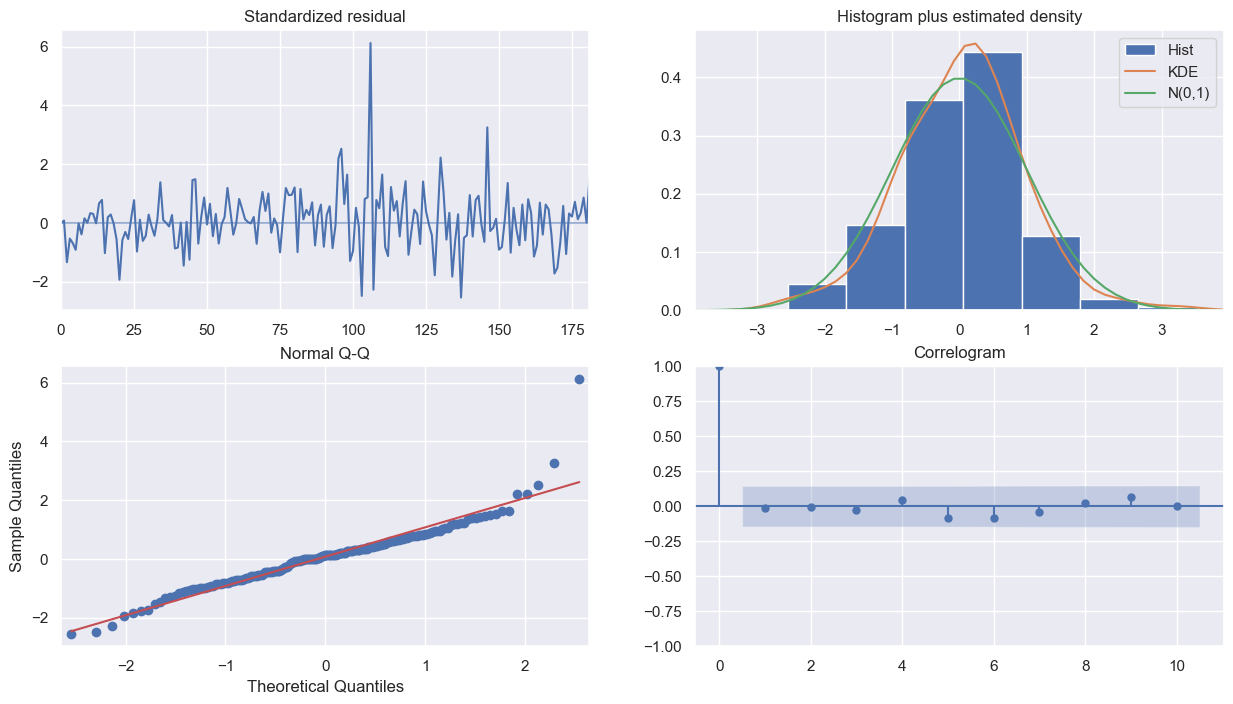

In [9]:
#applying autoarima model to the training data
from pmdarima.arima import auto_arima
smodel_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(smodel_autoARIMA.summary())
smodel_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [10]:
#building model using sarimax
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train_data, order=(2, 1, 2))
model_fit = model.fit()
print(model_fit.summary())

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  183
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -876.999
Date:                Wed, 21 Aug 2024   AIC                           1763.997
Time:                        16:04:08   BIC                           1780.017
Sample:                             0   HQIC                          1770.491
                                - 183                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.9573      0.023    -84.566      0.000      -2.003      -1.912
ar.L2         -0.9957      0.021    -47.334      0.000      -1.037      -0.955
ma.L1          1.9254      0.061     31.344      0.0

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


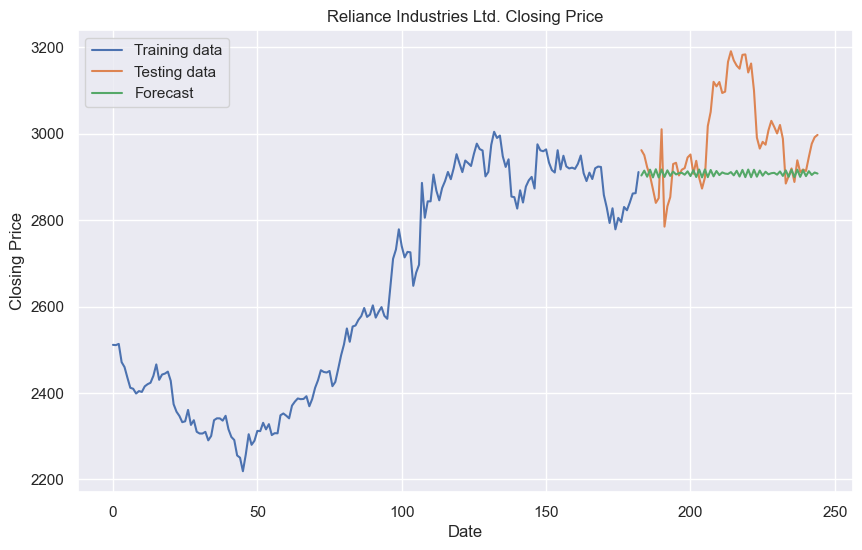

In [12]:
#Forecasting and prediction based on sarimax
forecast = model_fit.forecast(steps=len(test_data))
forecast = pd.Series(forecast, index=test_data.index)


#plotting the forecasted data
plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Training data')
plt.plot(test_data, label='Testing data')
plt.plot(forecast, label='Forecast')
plt.title('Reliance Industries Ltd. Closing Price')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.legend()
plt.show()


        Forecast  Lower Bound  Upper Bound
183  2903.453865  2845.061671  2961.846058
184  2914.664470  2833.394098  2995.934842
185  2900.653302  2800.560658  3000.745946
186  2916.913954  2801.943707  3031.884202
187  2899.039113  2770.124646  3027.953580
..           ...          ...          ...
240  2901.982096  2464.164512  3339.799680
241  2913.350334  2471.763700  3354.936969
242  2904.690916  2459.412444  3349.969388
243  2910.319826  2461.294639  3359.345013
244  2907.925128  2455.304890  3360.545367

[62 rows x 3 columns]


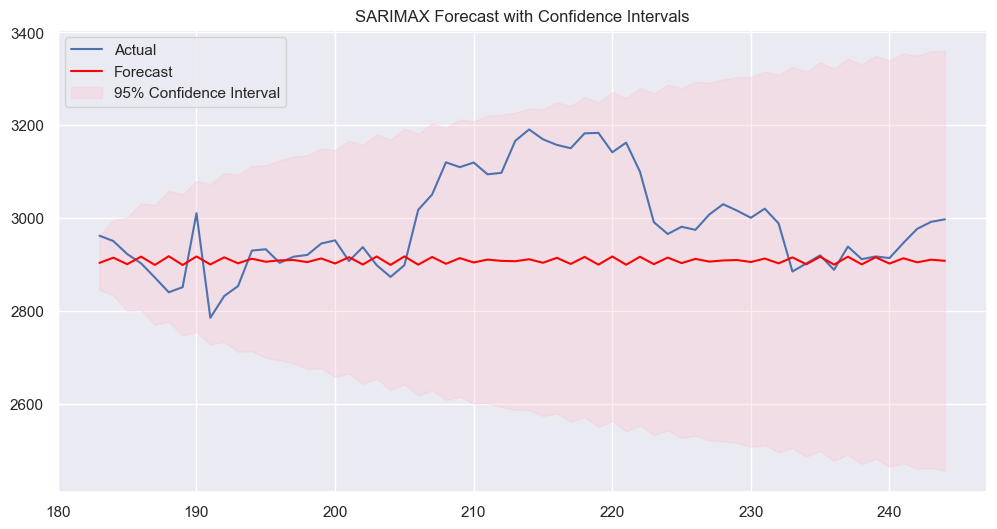

In [13]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have already fit your model and have your test data
# model = your fitted SARIMAX model
# test_data = your test dataset

# Get the number of periods in your test data
n_periods = len(test_data)

# Make the forecast
forecast = model_fit.get_forecast(steps=n_periods)

# Get the forecasted values
forecast_mean = forecast.predicted_mean

# Get the confidence intervals
confidence_intervals = forecast.conf_int()

# If you want 95% confidence interval
lower_bounds = confidence_intervals.iloc[:, 0]
upper_bounds = confidence_intervals.iloc[:, 1]

# Create a DataFrame with the results
results = pd.DataFrame({
    'Forecast': forecast_mean,
    'Lower Bound': lower_bounds,
    'Upper Bound': upper_bounds
})

# If your test_data is a Series with a DatetimeIndex, use:
# results.index = test_data.index
# Otherwise, if it's just a range of dates, you might need to set the index manually

# Print the results
print(results)

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data, label='Actual')
plt.plot(results.index, results['Forecast'], color='red', label='Forecast')
plt.fill_between(results.index, 
                 results['Lower Bound'], 
                 results['Upper Bound'], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')
plt.legend()
plt.title('SARIMAX Forecast with Confidence Intervals')
plt.show()

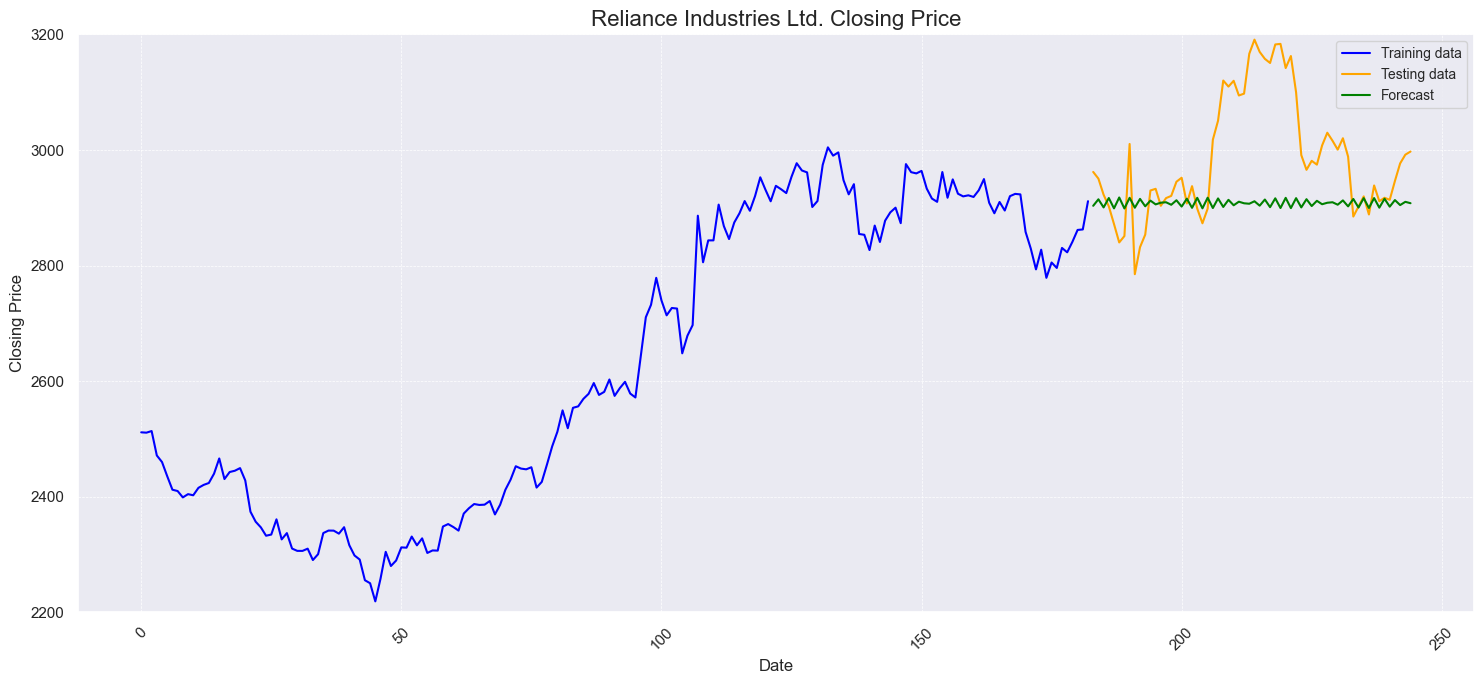

In [14]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have your data split into train_data and test_data
# and you've already fit your SARIMAX model

# Make the forecast
forecast = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# Create the plot
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train_data.index, train_data, label='Training data', color='blue')

# Plot testing data
plt.plot(test_data.index, test_data, label='Testing data', color='orange')

# Plot forecast
plt.plot(test_data.index, forecast_mean, label='Forecast', color='green')

# Customize the plot
plt.title('Reliance Industries Ltd. Closing Price', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Set y-axis limits similar to your image
plt.ylim(2200, 3200)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

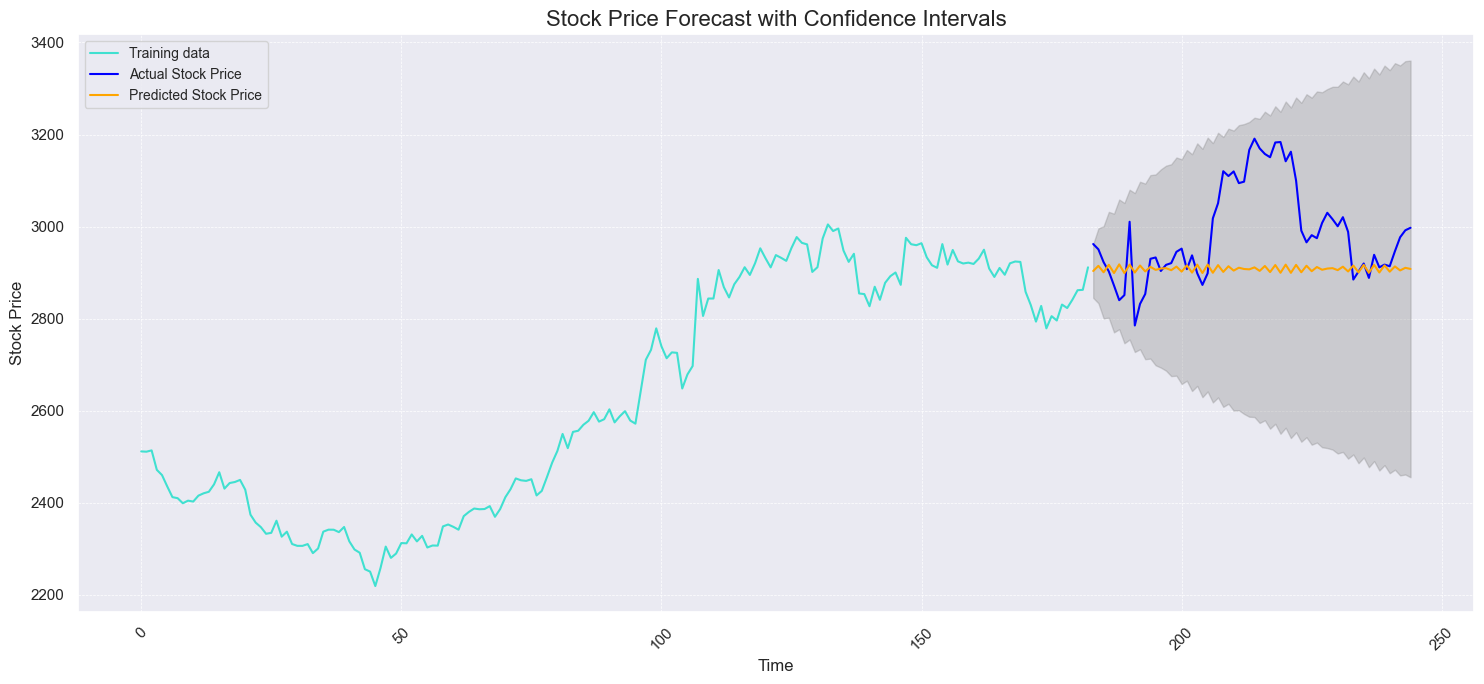

In [15]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# Assuming you have your data split into train_data and test_data
# and you've already fit your SARIMAX model

# Make the forecast
forecast = model_fit.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Create the plot
plt.figure(figsize=(15, 7))

# Plot training data
plt.plot(train_data.index, train_data, label='Training data', color='turquoise')

# Plot actual stock price (test data)
plt.plot(test_data.index, test_data, label='Actual Stock Price', color='blue')

# Plot predicted stock price
plt.plot(test_data.index, forecast_mean, label='Predicted Stock Price', color='orange')

# Plot confidence intervals
plt.fill_between(test_data.index, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='gray', alpha=0.3)

# Customize the plot
plt.title('Stock Price Forecast with Confidence Intervals', fontsize=16)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

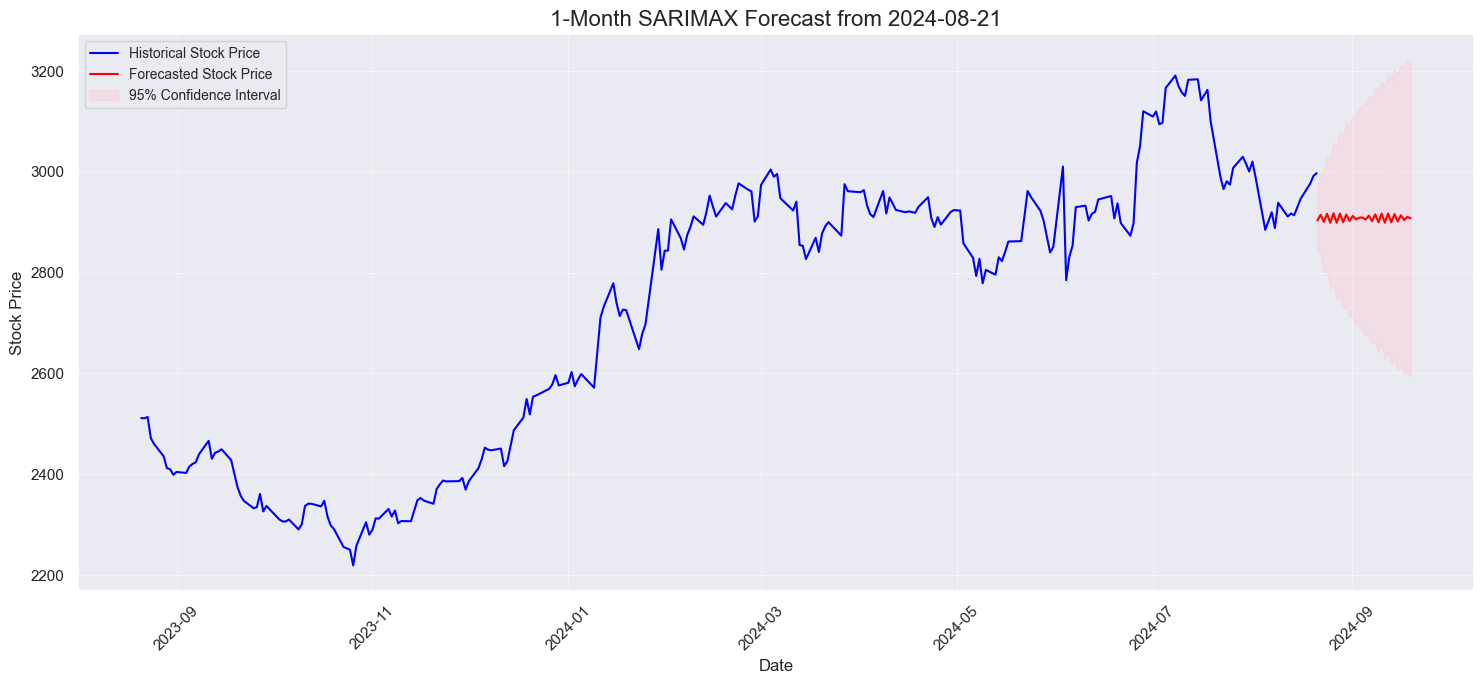

2024-08-21    2903.453865
2024-08-22    2914.664470
2024-08-23    2900.653302
2024-08-24    2916.913954
2024-08-25    2899.039113
2024-08-26    2917.833438
2024-08-27    2898.846759
2024-08-28    2917.294355
2024-08-29    2900.093422
2024-08-30    2915.391097
2024-08-31    2902.577241
2024-09-01    2912.424765
2024-09-02    2905.909885
2024-09-03    2908.855611
2024-09-04    2909.577200
2024-09-05    2905.231674
2024-09-06    2913.018494
2024-09-07    2902.104670
2024-09-08    2915.712217
2024-09-09    2899.946039
2024-09-10    2917.254968
2024-09-11    2899.075913
2024-09-12    2917.421850
2024-09-13    2899.615703
2024-09-14    2916.199166
2024-09-15    2901.471323
2024-09-16    2913.784708
2024-09-17    2904.349330
2024-09-18    2910.555874
2024-09-19    2907.803252
Freq: D, Name: predicted_mean, dtype: float64


In [17]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# Assuming you have your data and your SARIMAX model is already fit
# data = your full dataset
# model = your fitted SARIMAX model

# Set the forecast start date to today
today = datetime.now().date()

# Determine the number of days to forecast (approximately 1 month)
forecast_days = 30  # Adjust this if you want a different number of days

# Generate future dates starting from today
future_dates = pd.date_range(start=today, periods=forecast_days)

# Make the forecast
forecast = model_fit.get_forecast(steps=forecast_days)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Assign the future dates to the forecast results
forecast_mean.index = future_dates
confidence_intervals.index = future_dates

# Create the plot
plt.figure(figsize=(15, 7))

# Plot historical data
plt.plot(reliance_data['Date'], reliance_data['Close'], label='Historical Stock Price', color='blue')

# Plot forecasted values
plt.plot(future_dates, forecast_mean, label='Forecasted Stock Price', color='red')

# Plot confidence intervals
plt.fill_between(future_dates, 
                 confidence_intervals.iloc[:, 0], 
                 confidence_intervals.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

# Customize the plot
plt.title(f'1-Month SARIMAX Forecast from {today}', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Improve x-axis readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()

# Print the forecasted values
print(forecast_mean)

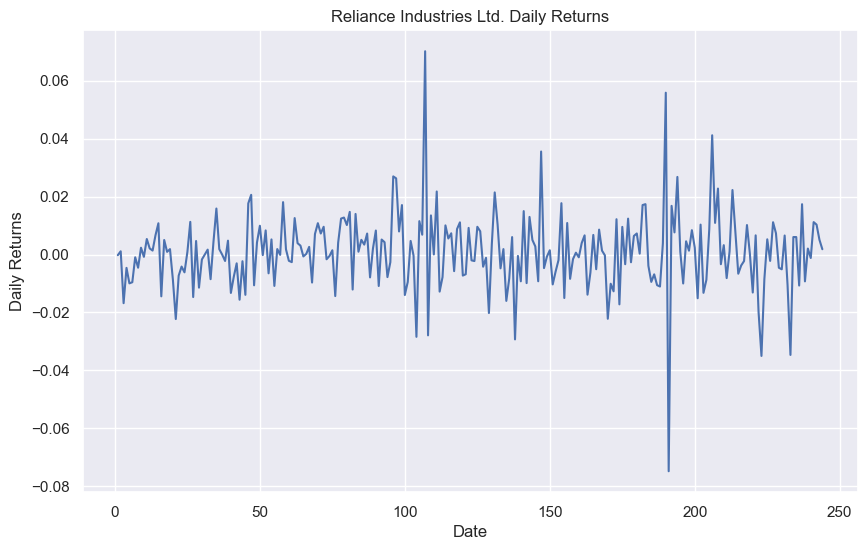

In [36]:
# returns and returns means
returns = reliance_data['Close'].pct_change().dropna()
returns_mean = returns.mean()

# Plot the returns
plt.figure(figsize=(10, 6))
plt.plot(returns)
plt.title('Reliance Industries Ltd. Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Returns')
plt.show()


In [38]:
#Measuring volatility, daily, monthly and annual
daily_volatility = returns.std()
monthly_volatility = returns.std() * np.sqrt(21)
annual_volatility = returns.std() * np.sqrt(252)

#Tabulate the results
volatility_data = pd.DataFrame({
    'Volatility': [daily_volatility, monthly_volatility, annual_volatility],
    'Period': ['Daily', 'Monthly', 'Annual']
})
print(volatility_data)


   Volatility   Period
0    0.013388    Daily
1    0.061353  Monthly
2    0.212533   Annual


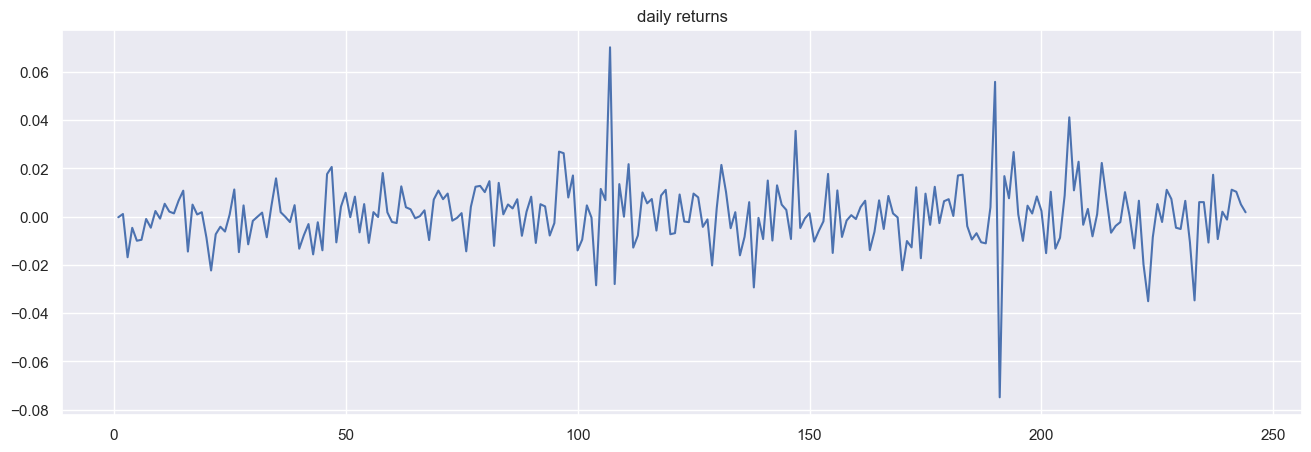

In [39]:
returns.plot(figsize =(16,5), title = 'daily returns');

In [41]:
return_dist_plot  = ff.create_distplot([returns.values.reshape(-1)], group_labels = [' '])
#We specify the plot layout
return_dist_plot.update_layout(showlegend=False, title_text='Distribution of daily Repsol Returns', width=1000, height=500)
#Printing the plot
return_dist_plot.show()

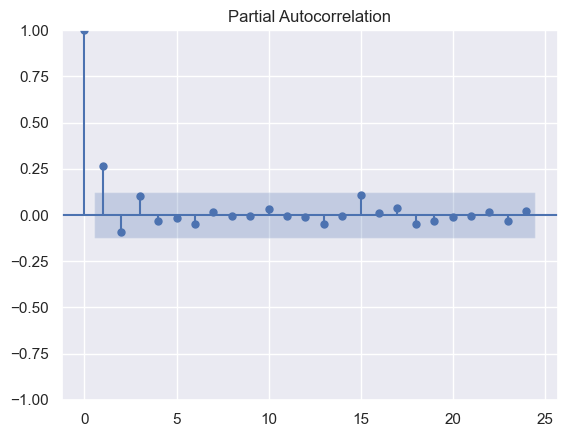

In [44]:
#This code uses the pacf() function from the tsa.stattools module of the statsmodels library (sm) to compute the autocorrelation function.
plot_pacf(returns**2,method="yw")
#Print the visualization
plt.show()

In [20]:
from arch import arch_model
import warnings
warnings.filterwarnings("ignore")

In [48]:

# Create a GARCH(1,1) model
model = arch_model(train_data, vol='Garch', p=2, q=2)
# Fit the model
model_fit_garch = model.fit()
# Print the model summary
model_fit_garch.summary()

Iteration:      1,   Func. Count:      8,   Neg. LLF: 1247.2037288213774
Iteration:      2,   Func. Count:     15,   Neg. LLF: 1250.0225480410213
Iteration:      3,   Func. Count:     23,   Neg. LLF: 1246.7837035779344
Iteration:      4,   Func. Count:     30,   Neg. LLF: 1246.6678917186473
Iteration:      5,   Func. Count:     37,   Neg. LLF: 1246.3272177449994
Iteration:      6,   Func. Count:     44,   Neg. LLF: 1254.3368303641014
Iteration:      7,   Func. Count:     52,   Neg. LLF: 1260.6847767608447
Iteration:      8,   Func. Count:     60,   Neg. LLF: 1244.8341957853036
Iteration:      9,   Func. Count:     68,   Neg. LLF: 1243.4867512720762
Iteration:     10,   Func. Count:     76,   Neg. LLF: 1223.0032882088196
Iteration:     11,   Func. Count:     83,   Neg. LLF: 1388.4354115321337
Iteration:     12,   Func. Count:     91,   Neg. LLF: 1202.9746683103406
Iteration:     13,   Func. Count:     98,   Neg. LLF: 1202.557172657133
Iteration:     14,   Func. Count:    105,   Neg. LLF

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:                  Close   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -1197.49
Distribution:                  Normal   AIC:                           2406.97
Method:            Maximum Likelihood   BIC:                           2426.23
                                        No. Observations:                  183
Date:                Wed, Aug 21 2024   Df Residuals:                      182
Time:                        17:25:39   Df Model:                            1
                                 Mean Model                                 
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu          2409.2563     14.983    160.797      0.000 [2.380e+03,2.439e+03]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega        235.9317    302.064      0.781      0.435 [-3.561e+02,8.280e+02]
alpha[1]       1.0000  6.751e-02     14.812  1.217e-49      [  0.868,  1.132]
alpha[2]       0.0000      0.442      0.000      1.000      [ -0.867,  0.867]
beta[1]        0.0000      0.441      0.000      1.000      [ -0.864,  0.864]
beta[2]        0.0000  1.438e-02      0.000      1.000 [-2.818e-02,2.818e-02]
=============================================================================

Covariance estimator: robust
"""

In [52]:
#Define the full serie as the previosly defined model
full_serie_garch = arch_model(returns,  vol = 'Garch', p=2, q=2)
#Fitting the model for the full serie
model_fit_full_serie = full_serie_garch.fit(disp='off')
#We will plot against the rolling volatility
rolling_vol = abs(returns.rolling(window=22, min_periods=22).std().dropna())
#Concatenating the true values, and trained values in our model
garch_and_rolling_std = pd.concat([pd.DataFrame(model_fit_full_serie.conditional_volatility),rolling_vol.dropna()], axis=1).dropna()
#Plotting it
garch_and_rolling_std_plot = px.line(garch_and_rolling_std, title = 'GARCH vs rolling volatility of daily returns TRAIN', width=1000, height=500)
#Printing the plot
garch_and_rolling_std_plot.show()

In [57]:
#Using a numeric range of 251 to fill a list of predicted values, for each day we are fitting a new model with the same parameters, but adding the last day.
test_size = 244
rolling_predictions = []

for i in range(test_size):
    train = returns[:-(test_size-i)]
    model = arch_model(returns, vol = 'GARCH', p=2, q=2)
    model_fit = model.fit(disp='off')
    pred = model_fit.forecast(horizon=1, reindex = False)
    rolling_predictions.append(np.sqrt(pred.variance.values[-1,:][0]))

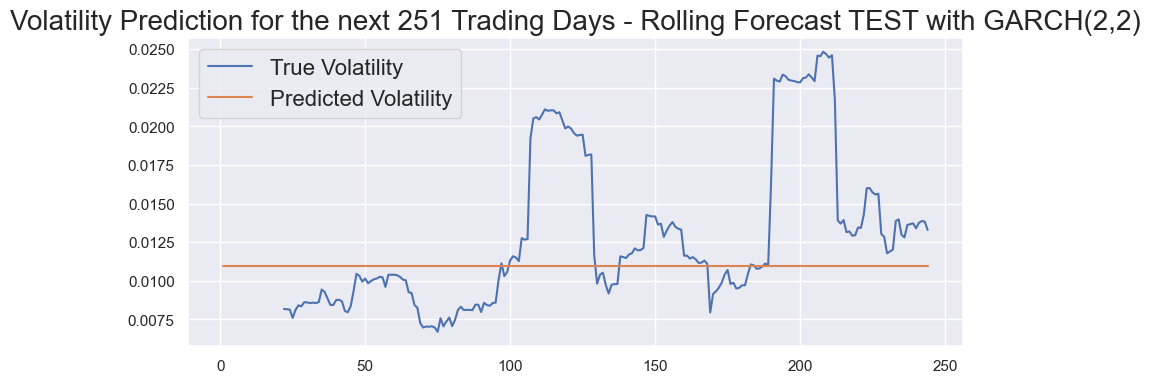

In [58]:
#Transforming it to a series
rolling_predictions = pd.Series(rolling_predictions, index= returns.dropna().index[-test_size:])
#Setting plot parameters
plt.figure(figsize=(10,4))
#True data 
true, = plt.plot((rolling_vol)[-test_size:])
#Predicted data
preds, = plt.plot(rolling_predictions)
#Plot of the data
plt.title('Volatility Prediction for the next 251 Trading Days - Rolling Forecast TEST with GARCH(2,2)', fontsize=20)
#Add legend
plt.legend(['True Volatility', 'Predicted Volatility'], fontsize=16)

### LSTM Predictions

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from datetime import datetime, timedelta

In [18]:
# 1. Prepare the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(pd.concat([train_data, test_data]).values.reshape(-1, 1))

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), 0])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

sequence_length = 60  # Number of time steps to look back
X, y = create_sequences(scaled_data, sequence_length)

In [19]:
# Split into train and test
train_size = len(train_data) - sequence_length
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [20]:
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(units=50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

d:\MLDL Projects\Financial Modelling\Financial Modelling & Analysis\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 187ms/step - loss: 0.2761 - val_loss: 0.0587
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0504 - val_loss: 0.0853
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0312 - val_loss: 0.0556
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0111 - val_loss: 0.0036
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0066 - val_loss: 0.0028
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0104 - val_loss: 0.0024
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0056 - val_loss: 0.0105
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0041 - val_loss: 0.0196
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0051 - val_loss: 0.0125
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0032 - val_loss: 0.0051
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0036 - val_loss: 0.0044
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0036 - val_l

In [22]:
# 4. Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


In [23]:
# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [24]:
# 5. Forecast next 30 days
last_sequence = scaled_data[-sequence_length:]
forecast = []

for _ in range(30):
    next_pred = model.predict(last_sequence.reshape(1, sequence_length, 1))
    forecast.append(next_pred[0, 0])
    last_sequence = np.roll(last_sequence, -1)
    last_sequence[-1] = next_pred

forecast = scaler.inverse_transform(np.array(forecast).reshape(-1, 1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

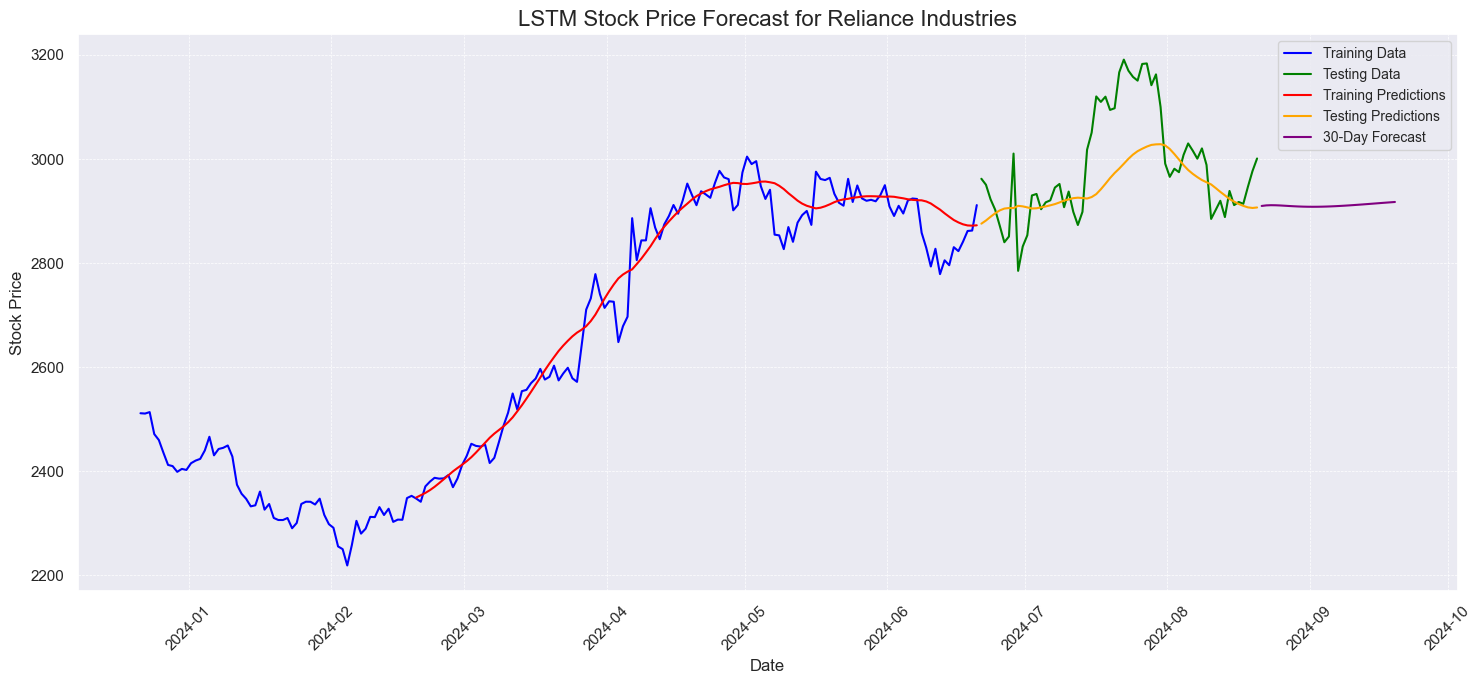

In [28]:
# 6. Plot results
plt.figure(figsize=(15, 7))

# Create a date range for the entire dataset
full_date_range = pd.date_range(start=datetime.now() - timedelta(days=len(train_data) + len(test_data) - 1), 
                                periods=len(train_data) + len(test_data))

# Plot historical data
plt.plot(full_date_range[:len(train_data)], train_data, label='Training Data', color='blue')
plt.plot(full_date_range[len(train_data):], test_data, label='Testing Data', color='green')

# Plot predictions
plt.plot(full_date_range[sequence_length:len(train_data)], train_predict, label='Training Predictions', color='red')
plt.plot(full_date_range[len(train_data):], test_predict, label='Testing Predictions', color='orange')

# Plot forecast
future_dates = pd.date_range(start=full_date_range[-1] + timedelta(days=1), periods=30)
plt.plot(future_dates, forecast, label='30-Day Forecast', color='purple')

plt.title('LSTM Stock Price Forecast for Reliance Industries', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Stock Price', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [31]:
# Print the forecasted values
print("30-Day Forecast:")
for date, price in zip(future_dates, forecast):
    print(f"{date}: {price[0]:.2f}")

30-Day Forecast:
1970-01-02 00:00:00.000000243: 2909.79
1970-01-03 00:00:00.000000243: 2910.88
1970-01-04 00:00:00.000000243: 2911.24
1970-01-05 00:00:00.000000243: 2911.12
1970-01-06 00:00:00.000000243: 2910.74
1970-01-07 00:00:00.000000243: 2910.22
1970-01-08 00:00:00.000000243: 2909.68
1970-01-09 00:00:00.000000243: 2909.20
1970-01-10 00:00:00.000000243: 2908.78
1970-01-11 00:00:00.000000243: 2908.47
1970-01-12 00:00:00.000000243: 2908.27
1970-01-13 00:00:00.000000243: 2908.20
1970-01-14 00:00:00.000000243: 2908.24
1970-01-15 00:00:00.000000243: 2908.38
1970-01-16 00:00:00.000000243: 2908.61
1970-01-17 00:00:00.000000243: 2908.93
1970-01-18 00:00:00.000000243: 2909.32
1970-01-19 00:00:00.000000243: 2909.79
1970-01-20 00:00:00.000000243: 2910.30
1970-01-21 00:00:00.000000243: 2910.86
1970-01-22 00:00:00.000000243: 2911.45
1970-01-23 00:00:00.000000243: 2912.08
1970-01-24 00:00:00.000000243: 2912.73
1970-01-25 00:00:00.000000243: 2913.40
1970-01-26 00:00:00.000000243: 2914.08
1970-01-